In [1]:
!pip install lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 20.7 MB/s eta 0:00:00


In [2]:
# ------------------- Preliminaries ------------------- #
import os
from dataclasses import dataclass
from typing import Tuple

import lightning as L
import pandas as pd
import seaborn as sn
import torch
from IPython.display import display
from lightning.pytorch.loggers import CSVLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST



In [4]:
@dataclass
class Config:
    """Configuration options for the Lightning MNIST example.

    Args:
        data_dir : The path to the directory where the MNIST dataset is stored. Defaults to the value of
            the 'PATH_DATASETS' environment variable or '.' if not set.

        save_dir : The path to the directory where the training logs will be saved. Defaults to 'logs/'.

        batch_size : The batch size to use during training. Defaults to 256 if a GPU is available,
            or 64 otherwise.

        max_epochs : The maximum number of epochs to train the model for. Defaults to 3.

        accelerator : The accelerator to use for training. Can be one of "cpu", "gpu", "tpu", "ipu", "auto".

        devices : The number of devices to use for training. Defaults to 1.

    Examples:
        This dataclass can be used to specify the configuration options for training a PyTorch Lightning model on the
        MNIST dataset. A new instance of this dataclass can be created as follows:

        >>> config = Config()

        The default values for each argument are shown in the documentation above. If desired, any of these values can be
        overridden when creating a new instance of the dataclass:

        >>> config = Config(batch_size=128, max_epochs=5)
    """

    data_dir: str = os.environ.get("PATH_DATASETS", ".")
    save_dir: str = "logs/"
    batch_size: int = 256 if torch.cuda.is_available() else 64
    max_epochs: int = 3
    accelerator: str = "auto"
    devices: int = 1


config = Config()


In [5]:
class LitMNIST(L.LightningModule):
    """PyTorch Lightning module for training a multi-layer perceptron (MLP) on the MNIST dataset.

    Attributes:
        data_dir : The path to the directory where the MNIST data will be downloaded.

        hidden_size : The number of units in the hidden layer of the MLP.

        learning_rate : The learning rate to use for training the MLP.

    Methods:
        forward(x):
            Performs a forward pass through the MLP.

        training_step(batch, batch_idx):
            Defines a single training step for the MLP.

        validation_step(batch, batch_idx):
            Defines a single validation step for the MLP.

        test_step(batch, batch_idx):
            Defines a single testing step for the MLP.

        configure_optimizers():
            Configures the optimizer to use for training the MLP.

        prepare_data():
            Downloads the MNIST dataset.

        setup(stage=None):
            Splits the MNIST dataset into train, validation, and test sets.

        train_dataloader():
            Returns a DataLoader for the training set.

        val_dataloader():
            Returns a DataLoader for the validation set.

        test_dataloader():
            Returns a DataLoader for the test set.
    """

    def __init__(self, data_dir: str = config.data_dir, hidden_size: int = 64, learning_rate: float = 2e-4):
        """Initializes a new instance of the LitMNIST class.

        Args:
            data_dir : The path to the directory where the MNIST data will be downloaded. Defaults to config.data_dir.

            hidden_size : The number of units in the hidden layer of the MLP (default is 64).

            learning_rate : The learning rate to use for training the MLP (default is 2e-4).
        """
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

        # Define PyTorch model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, self.num_classes),
        )

        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Performs a forward pass through the MLP.

        Args:
            x : The input data.

        Returns:
            torch.Tensor: The output of the MLP.
        """
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> torch.Tensor:
        """Defines a single training step for the MLP.

        Args:
            batch: A tuple containing the input data and target labels.

            batch_idx: The index of the current batch.

        Returns:
            (torch.Tensor): The training loss.
        """
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> None:
        """Defines a single validation step for the MLP.

        Args:
            batch : A tuple containing the input data and target labels.
            batch_idx : The index of the current batch.
        """
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch: Tuple[torch.Tensor, torch.Tensor], batch_nb: int) -> None:
        """Defines a single testing step for the MLP.

        Args:
            batch : A tuple containing the input data and target labels.
            batch_idx : The index of the current batch.
        """
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """Configures the optimizer to use for training the MLP.

        Returns:
            torch.optim.Optimizer: The optimizer.
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        return optimizer

    # ------------------------------------- #
    # DATA RELATED HOOKS
    # ------------------------------------- #

    def prepare_data(self) -> None:
        """Downloads the MNIST dataset."""
        MNIST(self.data_dir, train=True, download=True)

        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: str = None) -> None:
        """Splits the MNIST dataset into train, validation, and test sets.

        Args:
            stage : The current stage (either "fit" or "test"). Defaults to None.
        """
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)

            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the training set.

        Returns:
            DataLoader: The training DataLoader.
        """
        return DataLoader(self.mnist_train, batch_size=config.batch_size, num_workers=2)

    def val_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the validation set.

        Returns:
            DataLoader: The validation DataLoader.
        """
        return DataLoader(self.mnist_val, batch_size=config.batch_size)

    def test_dataloader(self) -> DataLoader:
        """Returns a DataLoader for the test set.

        Returns:
            DataLoader: The test DataLoader.
        """
        return DataLoader(self.mnist_test, batch_size=config.batch_size)


# %%
# Instantiate the LitMNIST model
model = LitMNIST()

# Instantiate a PyTorch Lightning trainer with the specified configuration
trainer = L.Trainer(
    accelerator=config.accelerator,
    devices=config.devices,
    max_epochs=config.max_epochs,
    logger=CSVLogger(save_dir=config.save_dir),
)

# Train the model using the trainer
trainer.fit(model)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 9912422/9912422 [00:00<00:00, 75749623.75it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25713371.65it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26453781.26it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21550371.91it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.220     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 55.1 K
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
-----------------------------------------------------
55.1 K    Trainable params
0         Non-trainable params
55.1 K    Total params
0.2

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=3` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [6]:
# ### Testing
#
# To test a model, call `trainer.test(model)`.
#
# Or, if you've just trained a model, you can just call `trainer.test()` and Lightning will automatically
# test using the best saved checkpoint (conditioned on val_loss).


trainer.test(ckpt_path="best")



INFO: Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at logs/lightning_logs/version_0/checkpoints/epoch=2-step=645.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9235000014305115     │
│         test_loss         │    0.2506667971611023     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2506667971611023, 'test_acc': 0.9235000014305115}]

In [34]:
!kill 9077

/bin/bash: line 1: kill: (9077) - No such process


In [36]:
%reload_ext tensorboard
%tensorboard --logdir "logs/lightning_logs"

Reusing TensorBoard on port 6006 (pid 9077), started 0:13:35 ago. (Use '!kill 9077' to kill it.)

<IPython.core.display.Javascript object>

,val_acc,val_loss,test_acc,test_loss
epoch,,,,
0,0.8930,0.415692,NaN,NaN
1,0.9154,0.302574,NaN,NaN
2,0.9242,0.264304,NaN,NaN
3,NaN,NaN,0.9235,0.250667


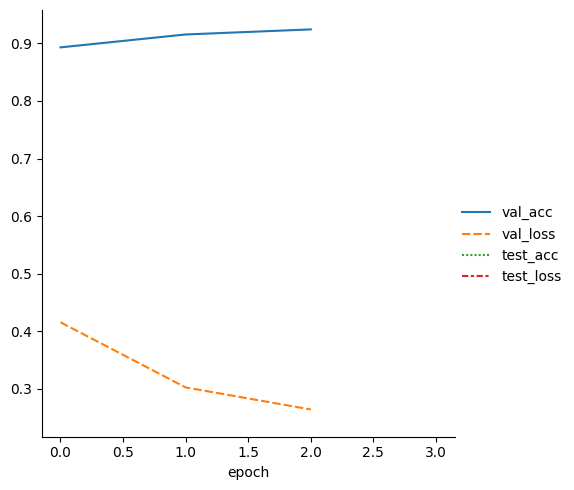

In [26]:
# Read in the training metrics from the CSV file generated by the logger
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

# Remove the "step" column, which is not needed for our analysis
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace=True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis=1, how="all").head())

# Create a line plot of the training metrics using Seaborn
sn.relplot(data=metrics, kind="line")